In [1]:
import pandas as pd
from pandas import read_csv, concat
from script.normalizer import normalize

deepdarkcti = read_csv('out/deepdarkcti.csv')
reddit2024 = read_csv('out/reddit2024.csv')
darknet = read_csv('out/darknet.csv')
ransomwatch = read_csv('out/ransomwatch.csv')
ransomfind = read_csv('out/ransomfind.csv')
ransomlook = read_csv('out/ransomlook.csv')
ransomwarelive = read_csv('out/ransomwarelive.csv')
ransomfeed = read_csv('out/ransomfeed.csv')

all_trackers = [deepdarkcti, reddit2024, darknet, ransomwatch, ransomfind, ransomlook, ransomwarelive, ransomfeed]

indexers = {
    'deepdarkcti': deepdarkcti,
    'reddit2024': reddit2024,
    'darknet': darknet,
    'ransomwatch': ransomwatch,
    'ransomfind': ransomfind,
    'ransomlook': ransomlook,
    'ransomwarelive': ransomwarelive,
    'ransomfeed': ransomfeed
}

normalize(all_trackers)

In [2]:
from pandas import concat

def replace_alias(name):
    if name in aliases:
        return replace_alias(aliases[name])
    return name

while True:
    aliases = dict()
    all_groups = concat(all_trackers)
    all_groups = all_groups.sort_values(by='Group')
    
    duplicates = dict()
    
    for _, entry in all_groups.iterrows():
        if entry['Link'] not in duplicates:
            duplicates[entry['Link']] = []
        if entry['Group'] not in duplicates[entry['Link']]:
            duplicates[entry['Link']].append(entry['Group'])
    
    for key in duplicates:
        if len(duplicates[key]) <= 1:
            continue
        alias = duplicates[key][0]
        for group in duplicates[key][1:]:
            aliases[group] = alias

    if len(aliases) == 0:
        break
            
    for tracker in all_trackers:
        tracker['Group'] = tracker['Group'].transform(lambda name: replace_alias(name))

all_groups = concat(all_trackers)
all_groups = all_groups.sort_values(by='Group')
all_groups

,Group,Link,Available,AvailableLabel
1,0mega,0mega.cc,True,True
257,0mega,omegalock5zxwbhswbisc42o2q2i54vdulyvtqqbudqous...,True,True
1,0mega,0mega.cc,True,True
0,0mega,omegalock5zxwbhswbisc42o2q2i54vdulyvtqqbudqous...,True,True
0,0mega,omegalock5zxwbhswbisc42o2q2i54vdulyvtqqbudqous...,True,True
...,...,...,...,...
141,zeon,zeonrefpbompx6rwdqa5hxgtp2cxgfmoymlli3azoanisz...,False,False
425,zero tolerance,zhuobnfsddn2myfxxdqtpxk367dqnntjf3kq7mrzdgienf...,False,True
371,zero tolerance,zhuobnfsddn2myfxxdqtpxk367dqnntjf3kq7mrzdgienf...,False,False
1341,zero tolerance,zhuobnfsddn2myfxxdqtpxk367dqnntjf3kq7mrzdgienf...,False,False


[16, 49, 13, 14, 24, 24]
[126, 15, 7, 198, 10, 10]


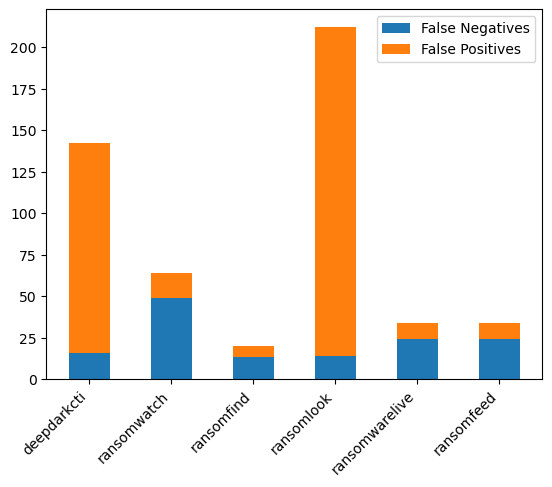

In [3]:
import numpy as np
from matplotlib import pyplot as plt

errors = { 'False Negatives': [], 'False Positives': [] }
indexer_names = []

for indexer in indexers:
    indexer_df = indexers[indexer]
    if 'AvailableLabel' not in indexer_df:
        continue

    false_negative = indexer_df[indexer_df['Available'] == True]
    false_negative = false_negative[false_negative['AvailableLabel'] == False]
    false_positive = indexer_df[indexer_df['Available'] == False]
    false_positive = false_positive[false_positive['AvailableLabel'] == True]

    indexer_names.append(indexer)
    errors['False Negatives'].append(len(false_negative))
    errors['False Positives'].append(len(false_positive))

fig, ax = plt.subplots()
plt.xticks(rotation=45, ha='right')

bottom = np.zeros(len(indexer_names))

for boolean, weight_count in errors.items():
    print(weight_count)
    p = ax.bar(indexer_names, weight_count, 0.5, label=boolean, bottom=bottom)
    bottom += weight_count

ax.legend(loc="upper right")

plt.show()

In [4]:
def get_tracked_status(only_active, indexer_dict: dict):
    tracking_status = { 'Group': [] }
    for i in indexer_dict.keys():
        tracking_status[i] = []

    concatted = all_groups
    if only_active:
        concatted = concatted[concatted['Available']]
    total = concatted['Group'].unique()

    for i in indexer_dict.keys():
        indexer = indexer_dict[i]
        if only_active:
            indexer = indexer[indexer['Available']]
        for group in total:
            tracking_status[i].append((indexer['Group'] == group).any())

    for group in total:
        tracking_status['Group'].append(group)

    return pd.DataFrame(tracking_status)

In [5]:
def get_tracked_status(only_active, indexer_dict: dict):
    tracking_status = { 'Group': [] }
    for i in indexer_dict.keys():
        tracking_status[i] = []

    concatted = all_groups
    if only_active:
        concatted = concatted[concatted['Available']]
    total = concatted['Group'].unique()

    for i in indexer_dict.keys():
        indexer = indexer_dict[i]
        if only_active:
            indexer = indexer[indexer['Available']]
        for group in total:
            tracking_status[i].append((indexer['Group'] == group).any())

    for group in total:
        tracking_status['Group'].append(group)

    return pd.DataFrame(tracking_status)

259 Gruppen


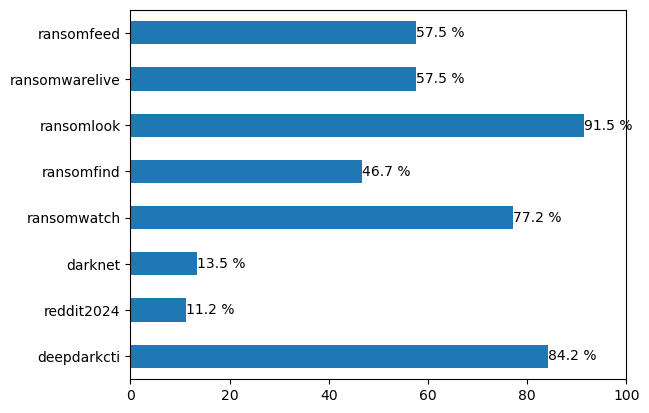

In [6]:
tracking_status_all = get_tracked_status(False, indexers)

groups_all = tracking_status_all['Group'].count()
relative_all = tracking_status_all.sum(numeric_only=True).transform(lambda x: x * 100 / groups_all)

ax_all = relative_all.plot.barh(xlim=[0, 100])
ax_all.bar_label(ax_all.containers[0], fmt="%.3g %%")
print(f"{groups_all} Gruppen")

94 Gruppen


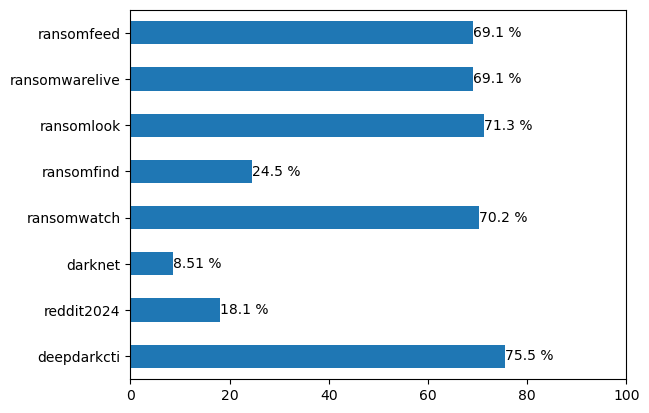

In [7]:
tracking_status_active = get_tracked_status(True, indexers)

groups_active = tracking_status_active['Group'].count()
relative_active = tracking_status_active.sum(numeric_only=True).transform(lambda x: x * 100 / groups_active)

ax_all = relative_active.plot.barh(xlim=[0, 100])
ax_all.bar_label(ax_all.containers[0], fmt="%.3g %%")
print(f"{groups_active} Gruppen")

[Text(0, 0, '7'), Text(0, 0, '22')]

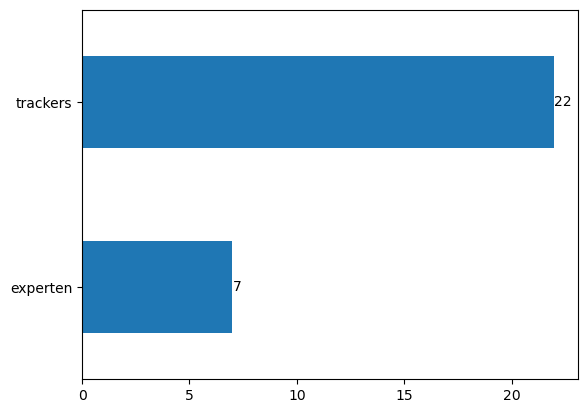

In [27]:
indexer_groups = {
    'experten': concat([darknet, reddit2024, deepdarkcti]),
    'trackers': concat([ransomwatch, ransomfind, ransomfeed, ransomlook])
}

tracking_status_active = get_tracked_status(True, indexer_groups)

unique_active = tracking_status_active[(tracking_status_active == True).sum(axis=1) == 1]

unique_active = unique_active.sum(numeric_only=True)

ax_all = unique_active.plot.barh()
ax_all.bar_label(ax_all.containers[0], fmt="%.3g")

[Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '2'),
 Text(0, 0, '10'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '7')]

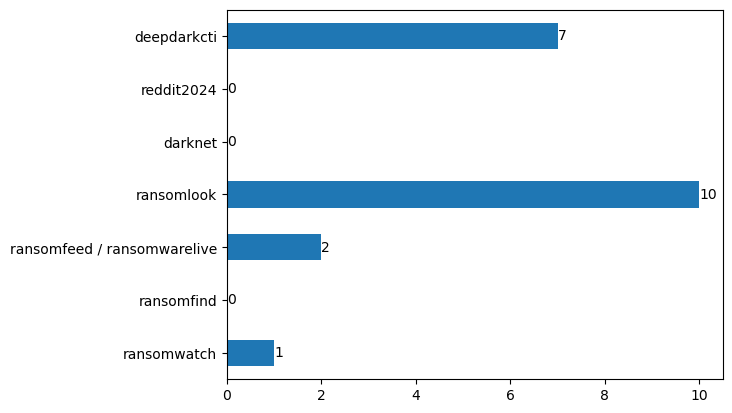

In [18]:
indexer_groups = {
    'ransomwatch': ransomwatch,
    'ransomfind': ransomfind,
    'ransomfeed / ransomwarelive': ransomfeed,
    'ransomlook': ransomlook,
    'darknet': darknet,
    'reddit2024': reddit2024,
    'deepdarkcti': deepdarkcti
}

tracking_status_active = get_tracked_status(True, indexer_groups)

unique_active = tracking_status_active[(tracking_status_active == True).sum(axis=1) == 1]

unique_active = unique_active.sum(numeric_only=True)

ax_all = unique_active.plot.barh()
ax_all.bar_label(ax_all.containers[0], fmt="%.3g")

In [10]:
import json
import pandas as pd

keywords = [
    "medical",
    "hospital",
    "clinic",
    "insur",
    "dent",
    "patient",
    "recover",
    "doctor",
    "nurs",
    "health",
    "facilit",
    "care",
    "lab",
    "pediat",
    "rehab",
    "krank",
    "mediz",
    "gesund",
]

with open("data/posts.json", "r") as f:
    ransomwarelive_posts = json.load(f)

df = pd.json_normalize(posts)

filtered = df['post_title'].apply(lambda d: any(keyword in d.lower() for keyword in keywords))

df = df[filtered]

df['discovered'] = pd.to_datetime(df['discovered'])
df['discovered'] = df['discovered'].dt.to_period('M')

df

FileNotFoundError: [Errno 2] No such file or directory: 'data/posts.json'

In [ ]:
from pandas import DataFrame, to_datetime

results_all = { 'Title': [], 'Group': [], 'Date': [] }
results_medical = { 'Title': [], 'Group': [], 'Date': [] }
for post in posts:
    title = post['post_title'].lower()
    results_all['Title'].append(post['post_title'])
    results_all['Group'].append(post['group_name'])
    results_all['Date'].append(post['discovered'])
    for keyword in keywords:
        if keyword in title:
            results_medical['Title'].append(post['post_title'])
            results_medical['Group'].append(post['group_name'])
            results_medical['Date'].append(post['discovered'])
            break

df_all = DataFrame(results_all)

df_all['Date'] = to_datetime(df_all['Date'])
df_all['Month'] = df_all['Date'].dt.to_period('M')
print(len(results_all['Title']))

data_all = df_all['Month'].value_counts()

df_medical = DataFrame(results_medical)

df_medical['Date'] = to_datetime(df_medical['Date'])
df_medical['Month'] = df_medical['Date'].dt.to_period('M')
print(len(results_medical['Title']))


data_medical = df_medical['Month'].value_counts()

all = DataFrame({
    'all': data_all,
    'medical': data_medical,
})
all['part'] = all['medical'] / all['all']
all